In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout,Embedding, Bidirectional, Conv1D, BatchNormalization, CuDNNLSTM, GlobalAveragePooling1D
from keras.layers import  MaxPooling1D, Embedding, concatenate, Flatten
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers, regularizers, initializers, layers, constraints
from keras.optimizers import Adam, RMSprop
from keras.engine.topology import Layer
from keras import backend as K
  

Using TensorFlow backend.


In [0]:
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def load_word_vectors(glove_dir):
    print('Indexing word vectors.')

    embeddings_index = {}
    f = open( glove_dir, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index
  
embeddings_index = load_word_vectors("/content/drive/My Drive/glove.6B.100d.txt")  

Indexing word vectors.
Found 400001 word vectors.


In [0]:
import pickle


pickle_in = open("/content/drive/My Drive/newlyrics.txt", "rb")
texts = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/newgenre.txt", "rb")
labels = pickle.load(pickle_in)

print("text size: %g" %len(texts))
print()
print("label size: %g" %len(labels))

from sklearn.preprocessing import LabelEncoder
# converts the character array to numeric array. Assigns levels to unique labels.

le = LabelEncoder() 
le.fit(labels)
labels = le.transform(labels)


print(le.classes_)
print(np.unique(labels, return_counts=True))


text size: 44195

label size: 44195
['Country' 'Hip-Hop' 'Metal' 'Pop' 'Rock']
(array([0, 1, 2, 3, 4]), array([8839, 8839, 8839, 8839, 8839]))


In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)

In [0]:
vocab_size=len(tokenizer.index_word)

sequence_length=1000

data = dict()

data["vocab_size"] = vocab_size

data["sequence_length"] = sequence_length

data["texts"] = texts

data["labels"] = labels

In [0]:
def tokenize_text(data):
    tokenizer = Tokenizer(num_words=data["vocab_size"])
    tokenizer.fit_on_texts(data["texts"])
    data["tokenizer"] = tokenizer
    sequences = tokenizer.texts_to_sequences(data["texts"])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data["X"] = pad_sequences(sequences, maxlen=data["sequence_length"])
    data["y"] = to_categorical(np.asarray(data["labels"]))
    print('Shape of data tensor:', data["X"].shape)
    print('Shape of label tensor:', data["y"].shape)

    # texts and labels aren't needed anymore
    data.pop("texts", None)
    data.pop("labels", None)
    return data
  
  
data = tokenize_text(data)



Found 185131 unique tokens.
Shape of data tensor: (44195, 1000)
Shape of label tensor: (44195, 5)


In [0]:
def train_val_test_split(data):

    data["X_train"], X_test_val, data["y_train"],  y_test_val = train_test_split(data["X"], data["y"], test_size=0.25)
    data["X_val"], data["X_test"], data["y_val"], data["y_test"] = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return data

data = train_val_test_split(data)  


In [0]:
def embedding_index_to_matrix(embeddings_index, vocab_size, embedding_dim, word_index):
    print('Preparing embedding matrix.')

    # prepare embedding matrix
    num_words = min(vocab_size, len(word_index))
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


data["embedding_dim"] = 100
data["embedding_matrix"] = embedding_index_to_matrix(embeddings_index=embeddings_index,
                                                         vocab_size=data["vocab_size"],
                                                         embedding_dim=data["embedding_dim"],
                                                         word_index=data["tokenizer"].word_index)

Preparing embedding matrix.


In [0]:

  
def build_network(vocab_size, embedding_dim, sequence_length, embedding_matrix):
  
    input = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=sequence_length,
                                trainable=False,
                                name="embedding")(input)
    
    
    
    x = Bidirectional(CuDNNLSTM(16, return_sequences=True))(embedding)
   
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dropout(0.5)(conc)
    conc = Dense(64, activation="relu",kernel_regularizer=regularizers.l1(0.001))(conc)
    
    output = Dense(5, activation="softmax")(conc)
    
    model = Model(inputs=input, outputs=output)

    adam=RMSprop(lr=5e-3,rho=0.9,decay=0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model  
  
  
model = build_network(vocab_size=data["vocab_size"],
                        embedding_dim=data['embedding_dim'],
                        sequence_length=data['sequence_length'],
                        embedding_matrix=data['embedding_matrix'])
print(model.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(data["X_train"], data["y_train"], batch_size=32, epochs=50,  callbacks=callbacks,shuffle=True,validation_data=(data["X_val"], data["y_val"]))

model.save("nusicGenre_model_word_embedding.h5")

score, acc = model.evaluate(x=data["X_test"], y=data["y_test"],batch_size=128)






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    18513100    input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 1000, 32)     15104       embedding[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d_5 (Glo (None, 32)           0           bidirectional_5[0][0]            
__________________________________________________________________________________________________
global_max

In [0]:
print(acc)

0.6485067874381985


In [0]:

#predictions on test data

predicted=model.predict(data["X_test"])
predicted

#model evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(data["y_test"], predicted.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("############################")

print(sklearn.metrics.classification_report(data["y_test"], predicted.round()))

precision: [0.71929825 0.86444008 0.79317477 0.62730061 0.58823529]
recall: [0.60979878 0.77876106 0.71084337 0.372835   0.00929368]
fscore: [0.66003788 0.81936685 0.74975562 0.46769583 0.01829826]
support: [1143 1130 1079 1097 1076]
############################
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      1143
           1       0.86      0.78      0.82      1130
           2       0.79      0.71      0.75      1079
           3       0.63      0.37      0.47      1097
           4       0.59      0.01      0.02      1076

   micro avg       0.76      0.50      0.60      5525
   macro avg       0.72      0.50      0.54      5525
weighted avg       0.72      0.50      0.55      5525
 samples avg       0.50      0.50      0.50      5525



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


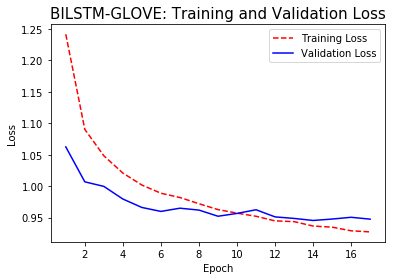

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('BILSTM-GLOVE: Training and Validation Loss',fontsize=15)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('BILSTM-GLOVE-VAL&TRAINING-LOSS.png')
plt.show();

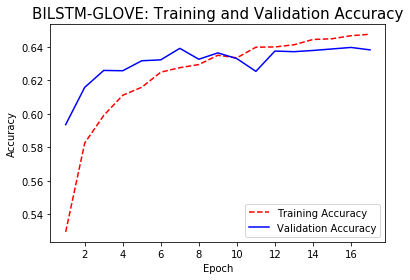

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['acc']
test_loss = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('BILSTM-GLOVE: Training and Validation Accuracy',fontsize=15)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('BILSTM-GLOVE-VAL&TRAINING_ACC.png')
plt.show();

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    
    plt.xlabel('Epochs')
    plt.title('BILSTM-GLOVE: Training and Validation Loss',fontsize=15)
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('BILSTM-GLOVE_VAL&TRAINING_LOSS.png')
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    
    plt.xlabel('Epochs')
    plt.title('BILSTM-GLOVE: Training and Validation Accuracy',fontsize=15)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('BILSTM-GLOVE_VAL&TRAINING_ACC.png')
    plt.show()
   

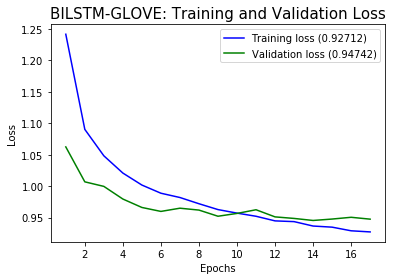

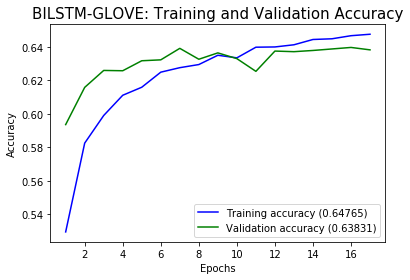

In [0]:
plot_history(history)

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)